# Time series statistics
Demonstration and exploration notebook
See also: *Time series statistics* reference poster

In [295]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import plotly.graph_objects as go

from matplotlib import pyplot as plt
from scipy import signal, fft
from astropy import timeseries

while ".toplevel" not in os.listdir():
    os.chdir("..")

plt.rcParams.update({"font.size": 14})

## Time series
Magnetic field interval from PSP

In [296]:
df = pd.read_pickle("data/processed/psp/psp_fld_l2_mag_rtn_201811.pkl")
x_df = df.loc[:, "B_R"][:10000]

if x_df.isnull().sum() == 0:
    print("No missing data")
else:
    print(f"{x_df.isnull().sum()} missing points")
print("Length of interval: " + str(x_df.notnull().sum()))
print("Duration of interval: " + str(x_df.index[-1] - x_df.index[0]))
x = x_df.values

No missing data
Length of interval: 10000
Duration of interval: 0 days 00:02:16.519881728


In [297]:
# Frequency of measurements
print("Duration between some adjacent data points:")
print(x_df.index[2] - x_df.index[1])
print(x_df.index[3] - x_df.index[2])
print(x_df.index[4] - x_df.index[3])

a = x_df.index[2] - x_df.index[1]
x_freq = 1 / (a.microseconds / 1e6)
print("\nFrequency is {0:.2f} Hz (2dp)".format(x_freq))

Duration between some adjacent data points:
0 days 00:00:00.013653376
0 days 00:00:00.013653248
0 days 00:00:00.013653248

Frequency is 73.24 Hz (2dp)


Text(0.5, 1.0, '140s of $B_R$ from PSP')

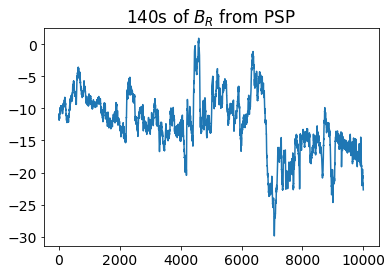

In [298]:
plt.plot(x)
plt.title("140s of $B_R$ from PSP")

Mean = $E(X) = \langle x \rangle = \bar{x} = \int_{-\infty}^{\infty} x\cdot p(X=x)$

In [299]:
print("Mean = {}".format(np.mean(x)))
print("Standard deviation = {}".format(np.std(x)))

Mean = -12.4821502587609
Standard deviation = 4.665649531350721


### Demo of removing and interpolating gaps

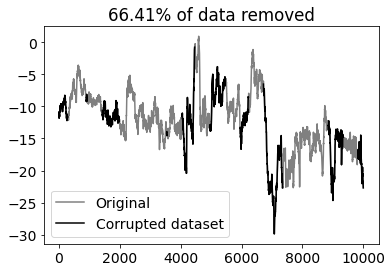

In [300]:
import ts_dashboard_utils
import importlib

importlib.reload(ts_dashboard_utils)

# Removing 50% of data in about 10 chunks
x_bad, x_bad_ind, prop_removed = ts_dashboard_utils.remove_data(pd.Series(x), 0.99, 20)
plt.plot(x, c="grey", label="Original")
plt.plot(x_bad, c="black", label="Corrupted dataset")
plt.title("{0:.2f}% of data removed".format(prop_removed * 100))
plt.legend()
plt.show()

In [310]:
%timeit ts_dashboard_utils.remove_data(x, 0.5, 10)

1.22 ms ± 247 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


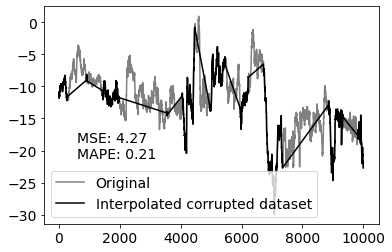

In [302]:
x_bad_adjacent = x_bad[pd.notna(x_bad)]
x_bad_interp = np.interp(np.arange(len(x)), x_bad_ind, x_bad_adjacent)

mse = ts_dashboard_utils.calc_mse(x, x_bad_interp)
mape = ts_dashboard_utils.calc_mape(x, x_bad_interp)

plt.plot(x, c="grey", label="Original")
plt.plot(x_bad_interp, c="black", label="Interpolated corrupted dataset")
plt.text(
    0.1,
    0.3,
    "MSE: {0:.2f}\nMAPE: {1:.2f}".format(mse, mape),
    transform=plt.gca().transAxes,
)
plt.legend()
plt.show()

### PDF of fluctuations

<AxesSubplot:xlabel='B_R', ylabel='Density'>

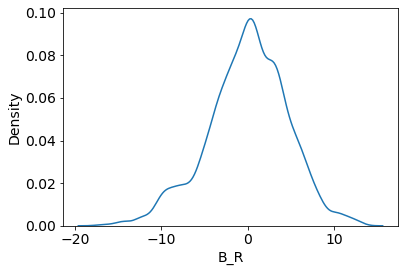

In [ ]:
sns.kdeplot(x_df - np.mean(x_df))

---

## Autocorrelation function
$$R(\tau)=\langle x(t+\tau)x(t) \rangle$$

In [ ]:
acovf = sm.tsa.acovf(x, nlag=9999)  # See whether this affects BT-method
# This uses the following code (if fft = False):
# xo = x - x.mean()
# acov = np.correlate(xo, xo, "full")[n - 1 :] / d[n - 1 :]

acf = acovf / acovf[0]  # same as sm.tsa.acf(x)


# By default, acovf() and acf() use the FFT, which is recommended for long time series

sfn = structure(x_df, [2], 1, 0.9999)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(acf, "g-")
ax2.plot(sfn["2"], "b-")

ax1.set_xlabel("Lag")
ax1.set_ylabel("Autocorrelation", color="g")
ax2.set_ylabel("2nd-order structure function", color="b")

NameError: name 'x_df' is not defined

In [ ]:
acf_from_sfn = 1 - sfn["2"] / (2 * acovf[0])

# plt.plot(acf, color='g')
# plt.plot(acf_from_sfn, color='b')
# plt.legend(["ACF", "ACF from second-order sfn"])
# plt.title("Autocorrelation")

fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(len(acf)), y=acf, name="ACF"))
fig.add_trace(
    go.Scatter(x=np.arange(len(acf)), y=acf_from_sfn, name="ACF from 2nd-order sfn")
)

# fig.update_xaxes(type="log", title_text="Frequency (Hz)")
# fig.update_yaxes(type="log", title_text='PSD [nT^2/Hz]') # Cannot get Latex to render
fig.update_layout(
    legend_title_text="Method", width=700, height=450, title_text="Autocorrelation"
)
fig.show()

## Power spectrum

### Fourier transform
Work through the scipy documentation https://docs.scipy.org/doc/scipy/tutorial/fft.html

In [ ]:
x[0:5]

array([-11.06131458, -10.85416412, -11.19788265, -11.00824833,
       -11.18834209])

In [ ]:
ft_x = fft.fft(x, norm="backward")  # Normalisation of 1/n only on the backward term
ft_x[0:5]

array([-124821.50258761    -0.j        ,   -6463.35991464-12560.39950741j,
          9982.76137474-11956.29300279j,   -3189.59329713 +2297.68864154j,
         -3891.0307961  -6037.97316072j])

In [ ]:
np.sum(x)

-124821.502587609

Note that the first term is equal to the sum of the series.

In [ ]:
ft_x_inv = fft.ifft(ft_x, norm="backward")
ft_x_inv[0:5]

array([-11.06131458-8.52651283e-17j, -10.85416412+9.27613542e-16j,
       -11.19788265+1.31592515e-15j, -11.00824833+1.65397108e-15j,
       -11.18834209+1.30739863e-16j])

Verified that inverse of fft is the original series (treating very small imaginary components as 0).

In [ ]:
def _next_regular(target):
    """
    Find the next regular number greater than or equal to target.
    Regular numbers are composites of the prime factors 2, 3, and 5.
    Also known as 5-smooth numbers or Hamming numbers, these are the optimal
    size for inputs to FFTPACK.

    Target must be a positive integer.
    """
    if target <= 6:
        return target

    # Quickly check if it's already a power of 2
    if not (target & (target - 1)):
        return target

    match = float("inf")  # Anything found will be smaller
    p5 = 1
    while p5 < target:
        p35 = p5
        while p35 < target:
            # Ceiling integer division, avoiding conversion to float
            # (quotient = ceil(target / p35))
            quotient = -(-target // p35)
            # Quickly find next power of 2 >= quotient
            p2 = 2 ** ((quotient - 1).bit_length())

            N = p2 * p35
            if N == target:
                return N
            elif N < match:
                match = N
            p35 *= 3
            if p35 == target:
                return p35
        if p35 < match:
            match = p35
        p5 *= 5
        if p5 == target:
            return p5
    if p5 < match:
        match = p5
    return match

##### Power spectra using different methods

In [ ]:
# Number of sample points
N = len(x)

# Sample spacing
T = 1 / x_freq

freqs = fft.fftfreq(N, T)
# This gives us the full set of sample frequencies for the Discrete Fourier Transform.
# There are both positive and negative frequencies, but the function is symmetric, so we can just take the first (positive)
# half as our values for the x-axis of the power spectrum

# x-axis values (length N/2)
freqs_positive = fft.fftfreq(N, T)[: N // 2]

# To get the y-values, we similarly need to select the values of the Fourier transform for the positive frequencies.
# We can also use fft.rfft(x) for this, noting that this array is of length (N/2)+1 rather than N/2

power_ft = 1.0 / N * np.abs(ft_x[0 : (N // 2)]) ** 2

# FFT with windowing method to prevent spectral leakage by enforcing periodicity on an aperiodic signal
# boxcar = rectangular window = no window
w = signal.windows.boxcar(N)
ft_x_w = fft.fft(x * w)
power_ft_w = 1.0 / N * np.abs(ft_x_w[0 : (N // 2)]) ** 2

# The power spectrum can be estimated directly, with the option of a window, using periodogram()

f_periodogram, power_periodogram = signal.periodogram(
    x, fs=x_freq, window="boxcar", scaling="density"
)
power_periodogram = (x_freq / 2) * power_periodogram  # Correcting scaling

# You can create smoother spectra by additionally averaging across (possibly overlapping) segments
# with welch(). This method reduces noise at the expense of reducing the frequency resolution

f_welch, power_welch = signal.welch(
    x, fs=x_freq, window="boxcar", scaling="density", nperseg=len(x)
)
power_welch = (x_freq / 2) * power_welch  # Correcting scaling
# Set nperseg=len(x) to get identical spectrum to periodogram() (only one segment)
# Set noverlap=0 and window = "boxcar" to get Bartlett's method (averaging but no overlap or windowing)

# Note scaling for both of the methods above, shown inside _spectral_helper():
## if scaling = 'density' (and mode = 'psd', default), the result is multiplied by 2.0 / (fs * (win*win).sum())

# PSD estimation using Lomb-Scargle method (typically used for incomplete signals)
# See here for details: http://jakevdp.github.io/blog/2017/03/30/practical-lomb-scargle/

## Using scipy
freqs_positive_angular = (
    (freqs_positive + 10e-100) * 2 * np.pi
)  # Fixing issue with float division
power_ls_scipy = signal.lombscargle(
    np.arange(N) / x_freq, x, freqs_positive_angular, normalize=False
)

## Using astropy
power_ls_astropy = timeseries.LombScargle(
    np.arange(N) / x_freq, x, normalization="psd"
).power(freqs_positive[1:])


# Using smoothing function from Tulasi
def SmoothySpec(a, nums=None):
    b = a.copy()
    if nums is None:
        nums = 2 * len(b) // 3
    for i in range(nums):
        b[i + 1 : :][:-1] = (
            0.25 * b[i::][:-2] + 0.5 * b[i + 1 : :][:-1] + 0.25 * b[i::][2:]
        )
    return b


power_smooth = SmoothySpec(power_ft)

# Using Fourier transform of autocorrelation function

# (Blackman-Tukey method, utilising Wiener-Khinchin theorem)
# See Matthaeus & Goldstein (1982) for comparison of methods

# Typically this also involves windowing
# w = signal.windows.bartlett(N/5)

# Including negative lags (symmetric function)
full_acovf = np.zeros(2 * 10000)
full_acovf[10000 : 10000 * 2] = acovf
full_acovf[0:10000] = acovf[::-1]

ft_acovf = fft.fft(full_acovf)
power_ft_acovf_real = np.real(ft_acovf)

w_acf = np.pad(
    signal.windows.cosine(len(full_acovf) * 0.1),
    pad_width=int(0.5 * (1 - 0.1) * len(full_acovf)),
)
ft_acovf_window = fft.fft(w_acf * full_acovf)
power_ft_acovf_real_w = np.real(ft_acovf_window)

# This gets us very close. The following steps may get us closer:
# Kkeep +ve values (of BT method), else look at Parseval's theorem
# (Need to include -ve values of psd)
# Pi = np.sum(np.abs(im)**2) # raw data (Mark had np.mean() instead)
# Pf = np.sum(fek) # power spec
# print(n, Pi, Pf, Pi == Pf)


# Equivalent spectrum using second-order structure function (Chhiber et al., 2018)

sfn = calc_sfn(x_df, p=[2], freq=x_freq, max_lag_prop=0.99)  # freq = x_freq
sfn["s2*lag"] = sfn["2"] * sfn["lag"]
freqs_es = 1 / sfn["lag"]
power_es = sfn["s2*lag"]

###########################################################################################

# Interactive plot
# Allows easy comparision of different methods: remove certain lines, zoom in, pan, etc.
# BUGS: Cannot get Latex to render and axis labels are weird

fig = go.Figure()

fig.add_trace(go.Scatter(x=freqs_positive, y=power_ft, name="FT"))
fig.add_trace(
    go.Scatter(x=freqs_positive, y=power_ls_scipy, name="Lomb-Scargle (scipy)")
)
fig.add_trace(
    go.Scatter(x=freqs_positive[1:], y=power_ls_astropy, name="Lomb-Scargle (astropy)")
)
fig.add_trace(go.Scatter(x=freqs_positive, y=power_ft_w, name="FT w. window"))
fig.add_trace(
    go.Scatter(x=freqs_positive[1:], y=power_periodogram[1:], name="Peridogram")
)
# Periodogram method has silly first value that affects plotting, hence indices. If using proper Welch, remove these.
fig.add_trace(go.Scatter(x=f_welch[1:], y=power_welch[1:], name="Welch"))

fig.add_trace(
    go.Scatter(
        x=freqs_positive,
        y=power_ft_acovf_real[power_ft_acovf_real > 0][: len(power_ft)],
        name="Blackman-Tukey",
    )
)
fig.add_trace(
    go.Scatter(
        x=freqs_positive,
        y=power_ft_acovf_real_w[power_ft_acovf_real_w > 0][: len(power_ft)],
        name="Blackman-Tukey w. window",
    )
)

fig.add_trace(go.Scatter(x=freqs_positive, y=power_smooth, name="SmoothySpec"))
fig.add_trace(
    go.Scatter(x=freqs_es, y=power_es, name="Equivalent spectrum")
)  # Note translation of curve to align with true spectra
# fig.add_trace(go.Scatter(x=freqs_positive, y=power_ft_acovf_real, name = "Blackman-Tukey (Real)"))
# fig.add_trace(go.Scatter(x=freqs_positive, y=power_ft_acovf_abs_sqd_norm, name = "Blackman-Tukey (Abs->Sqd->Norm)"))


fig.add_trace(
    go.Scatter(
        x=freqs_positive[1:],
        y=1000 * freqs_positive[1:] ** (-5 / 3),
        name="-5/3 power law",
    )
)

fig.update_xaxes(type="log", title_text="Frequency (Hz)")
fig.update_yaxes(type="log", title_text="PSD [nT^2/Hz]")
fig.update_layout(
    legend_title_text="Method",
    width=700,
    height=450,
    title_text="Power spectrum of scalar PSP interval via different methods",
)
fig.show()

Parseval's theorem. (Can't seem to get it to work for BT method)

In [ ]:
np.round(np.sum(x**2), 5) == np.round(np.sum(1.0 / N * np.abs(ft_x) ** 2), 5)

True

[]

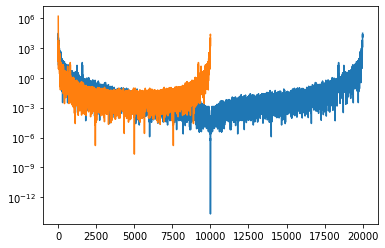

In [ ]:
plt.plot(np.abs(power_ft_acovf_real))
plt.plot(1.0 / N * np.abs(ft_x) ** 2)
plt.semilogy()

### Demonstrating the window functions

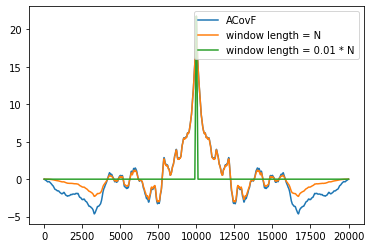

In [ ]:
w_N = signal.windows.cosine(len(full_acovf))
w_001 = np.pad(
    signal.windows.cosine(len(full_acovf) * 0.01),
    pad_width=int(0.5 * (1 - 0.01) * len(full_acovf)),
)

plt.plot(full_acovf, label="ACovF")
plt.plot(w_N * full_acovf, label="window length = N")
plt.plot(w_001 * full_acovf, label="window length = 0.01 * N")
plt.legend()
plt.show()

- The advantage of the BT technique is that the goal that R(r) -> 0 can be checked.
- The advantage of the equivalent spectra is that is much smoother than the power spectrum but still captures all the features. We can also add “true”, single-value structure functions calculated from multi-spacecraft measurements where we don’t need to assume Taylor’s hypothesis.
- **See Mark's notebook for nice diagrams of different windows**

Non-interactive `matplotlib` version

In [ ]:
# plt.semilogy(freqs_positive, 2.0/N * np.abs(ft_x[0:(N//2)])**2)
# plt.semilogy(freqs_positive, 2.0/N * np.abs(ft_x_window[0:(N//2)])**2)
# plt.semilogy(f, 2.0/N * power_periodogram)
# plt.semilogy(freqs_positive, 2.0/N * power_ls_scipy)
# plt.semilogy(f_welch, 2.0/N * power_welch)
# plt.semilogy(freqs_positive, 2.0/N * np.real(ft_acf[0:(N//2)]))
# plt.semilogy(freqs_positive[1:], power_ls_astropy)
# plt.legend(['FFT', 'FFT w. window', 'Periodogram','Lomb-Scargle (scipy)', 'Welch', "FFT of ACF", "Lomb-Scargle (astropy)"])
# plt.semilogx()
# plt.xlabel('frequency [Hz]')
# plt.ylabel('PSD')
# plt.title("Power spectrum for a PSP interval via different methods")
# plt.grid()
# plt.show()



# Statistics in 3D
In 3D, we get statistics such as the ACF and power spectrum from the **trace** of the corresponding **matrix**. For example, the ACF for each vector component $x,y,z$ is given by the *diagonal components* of the ACF matrix: 

$R(\tau)=\text{trace}  R_{ij}(\tau)$

$R_{ij}(\tau)=\langle\delta B_i(t)\delta B_j(t+\tau)\rangle$

For power spectra $E(k)$ in three dimensions, we can use a perpendicular spectrum (see `TurbAn\Analysis\Simulations\AnalysisFunctions.py`), or a 3D spectrum and calculate the modulus (talk to Mark about this)

# Other datasets

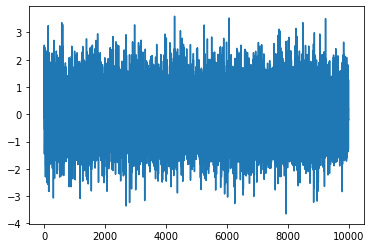

In [ ]:
white_noise = np.random.randn(10000)
plt.plot(white_noise)

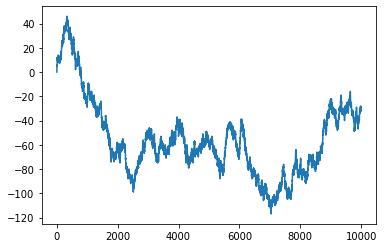

In [ ]:
import random

random.seed(42)


def randomwalk1D(n):
    x, y = 0, 0
    # Generate the time points [1, 2, 3, ... , n]
    timepoints = np.arange(n + 1)
    positions = [y]
    directions = ["UP", "DOWN"]
    for i in range(1, n + 1):
        # Randomly select either UP or DOWN
        step = random.choice(directions)

        # Move the object up or down
        if step == "UP":
            y += 1
        elif step == "DOWN":
            y -= 1
        # Keep track of the positions
        positions.append(y)
    return timepoints, positions


time_data, pos_data = randomwalk1D(10000)
plt.plot(time_data, pos_data)